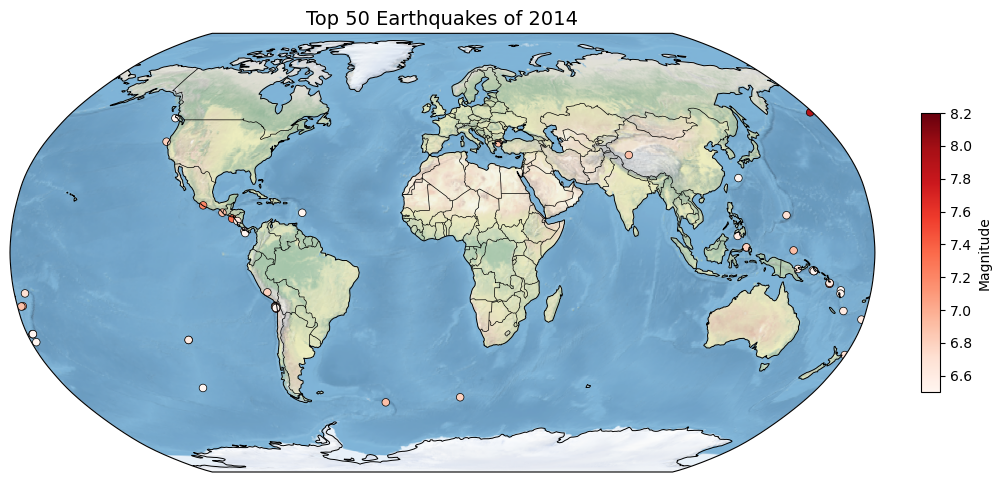

In [16]:
# ========== 1.1 ==========
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 读取 CSV 文件
df = pd.read_csv("usgs_earthquakes.csv")

# 转换时间列
df['time'] = pd.to_datetime(df['time'], errors='coerce')
df_2014 = df[df['time'].dt.year == 2014]

# 去掉缺少经纬度或震级的数据
df_2014 = df_2014.dropna(subset=['latitude', 'longitude', 'mag'])

# 取震级最高的50个事件
top50 = df_2014.nlargest(50, 'mag')

# 绘图
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()
ax.coastlines(linewidth=0.7)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)

ax.stock_img()

# 绘制散点
sc = plt.scatter(
    top50['longitude'], top50['latitude'],
    c=top50['mag'], cmap='Reds', s=30,
    edgecolor='black', linewidths=0.5,
    transform=ccrs.PlateCarree()
)

# 添加颜色条和标题
cbar = plt.colorbar(sc, orientation='vertical', pad=0.05,fraction=0.02, aspect=15)
cbar.set_label('Magnitude')
plt.title("Top 50 Earthquakes of 2014", fontsize=14)
plt.show()


In [18]:

import xarray as xr

# 读取文件
ds = xr.open_dataset("lai_Lmon_CESM1-CAM5-SE-HR_highres-future_r1i1p1f1_gn_201501-205012.nc")

# 查看数据信息
print(ds)

C:\Users\10147\anaconda3\Lib\site-packages\xarray\conventions.py:204: SerializationWarning: variable 'lai' has multiple fill values {np.float32(1e+20), np.float64(1e+20)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


<xarray.Dataset> Size: 1GB
Dimensions:    (time: 432, lndgrid: 777602, hist_interval: 2, grid_corners: 5)
Coordinates:
    lat        (lndgrid) float64 6MB ...
    lon        (lndgrid) float64 6MB ...
  * time       (time) object 3kB 2015-01-15 12:00:00 ... 2050-12-15 12:00:00
Dimensions without coordinates: lndgrid, hist_interval, grid_corners
Data variables:
    lai        (time, lndgrid) float32 1GB ...
    time_bnds  (time, hist_interval) object 7kB ...
    lat_bnds   (lndgrid, grid_corners) float32 16MB ...
    lon_bnds   (lndgrid, grid_corners) float32 16MB ...
Attributes: (12/46)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            HighResMIP
    branch_method:          standard
    branch_time_in_child:   711750.0
    branch_time_in_parent:  711750.0
    case_id:                1768
    ...                     ...
    sub_experiment_id:      none
    table_id:               Lmon
    tracking_id:            hdl:21.14100/4acfe760-ac24-4bff-80da-8b1befea0ba6
   

ModuleNotFoundError: No module named 'ESMF'

C:\Users\10147\anaconda3\Lib\site-packages\xarray\conventions.py:204: SerializationWarning: variable 'lai' has multiple fill values {np.float32(1e+20), np.float64(1e+20)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


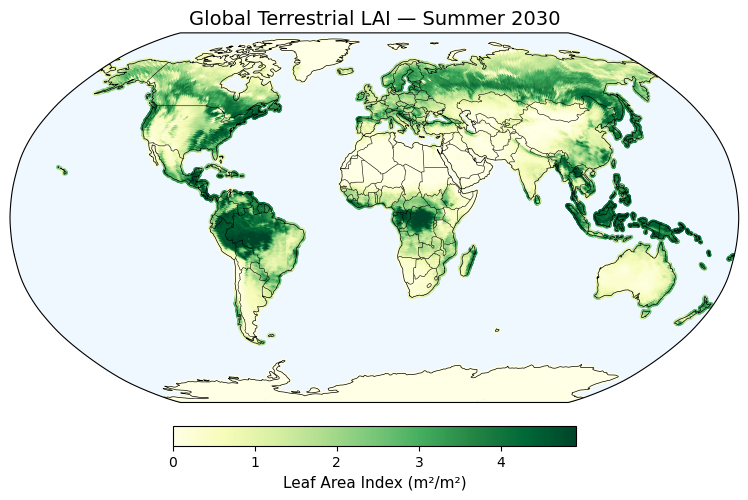

C:\Users\10147\AppData\Local\Temp\ipykernel_13840\2612207848.py:92: FutureWarning: In a future version of xarray to_datetimeindex will default to returning a 'us'-resolution DatetimeIndex instead of a 'ns'-resolution DatetimeIndex. This warning can be silenced by explicitly passing the `time_unit` keyword argument.
  time_index = pd.to_datetime(lai_global_mean.indexes["time"].to_datetimeindex())
C:\Users\10147\AppData\Local\Temp\ipykernel_13840\2612207848.py:92: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  time_index = pd.to_datetime(lai_global_mean.indexes["time"].to_datetimeindex())


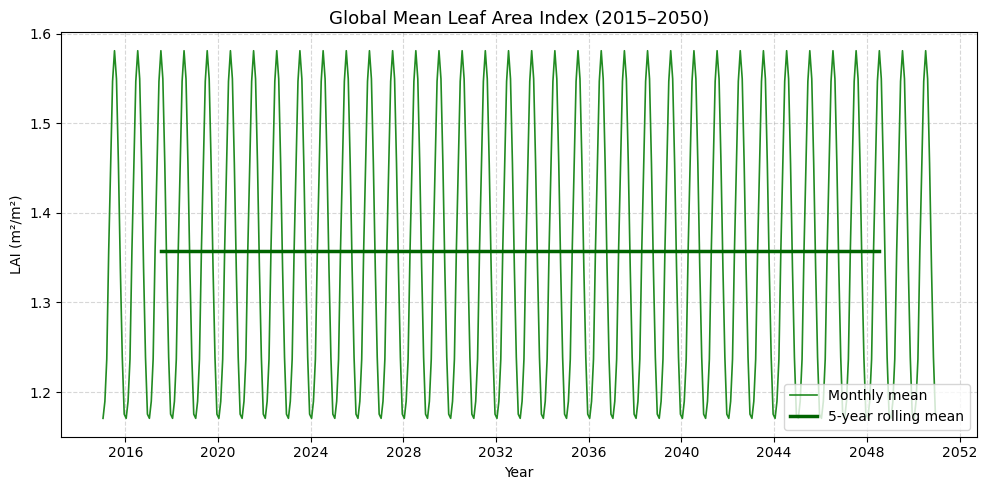

Global mean LAI (2015–2050): 1.3577965017426465
Temporal std dev: 0.14903561358669198


In [41]:
# ========== 2.1 ==========


import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point
from cartopy import io
import shapely.vectorized


# ======================================================
# 读取数据
# ======================================================
ds = xr.open_dataset(
    "lai_Lmon_CESM1-CAM5-SE-HR_highres-future_r1i1p1f1_gn_201501-205012.nc",
    decode_times=True
)
lai = ds["lai"]
lat = ds["lat"].values
lon = ds["lon"].values
# 若经度超过 180，则减掉 360 —— 把所有经度统一到 -180–180
lon = np.where(lon > 180, lon - 360, lon)
# ======================================================
# 提取 2030 年夏季平均 (JJA)
# ======================================================
mask_2030 = (lai["time"].dt.year == 2030) & (lai["time"].dt.month.isin([6,7,8]))
lai_2030_JJA = lai.sel(time=mask_2030).mean("time")
lai_vals = lai_2030_JJA.values



# ======================================================
# 构造陆地 mask
# ======================================================
land_feature = cfeature.NaturalEarthFeature("physical", "land", "110m")
land_geoms = list(land_feature.geometries())

# 用 shapely 检查哪些点落在陆地区域
points = np.vstack([lon, lat]).T
mask_land = np.zeros(len(points), dtype=bool)
for geom in land_geoms:
    mask_land |= shapely.vectorized.contains(geom, lon, lat)

# 只保留陆地
lai_land = np.where(mask_land, lai_vals, np.nan)


# ======================================================
# 绘制全球陆地 LAI (JJA 2030)
# ======================================================
fig = plt.figure(figsize=(13,6))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()

# 地理底图 (features)
ax.add_feature(cfeature.LAND, facecolor="lightgray", edgecolor="gray")
ax.add_feature(cfeature.OCEAN, facecolor="aliceblue")
ax.add_feature(cfeature.BORDERS, linewidth=0.4)
ax.coastlines(linewidth=0.5)

# 只绘制陆地点
sc = ax.scatter(lon, lat, c=lai_land, s=4,
                cmap="YlGn", transform=ccrs.PlateCarree(),
                vmin=np.nanpercentile(lai_land, 1),
                vmax=np.nanpercentile(lai_land, 99))

cb = plt.colorbar(sc, orientation="horizontal", pad=0.05, shrink=0.4)
cb.set_label("Leaf Area Index (m²/m²)", fontsize=11)
plt.title("Global Terrestrial LAI — Summer 2030", fontsize=14)

plt.show()



# ======================================================
# 计算全球加权平均（lndgrid 结构）
# ======================================================

weights = xr.DataArray(np.cos(np.deg2rad(ds["lat"])),
                       dims=["lndgrid"],
                       coords={"lndgrid": ds["lndgrid"]})

lai_global_mean = lai.weighted(weights).mean("lndgrid")

# ======================================================
# 将时间转为 pandas DatetimeIndex
# ======================================================
try:
    time_index = pd.to_datetime(lai_global_mean.indexes["time"].to_datetimeindex())
except Exception:
    time_index = pd.to_datetime(lai_global_mean["time"].astype(str))

# ======================================================
# 绘制时间序列
# ======================================================
plt.figure(figsize=(10,5))
plt.plot(time_index, lai_global_mean, color="forestgreen", lw=1.2, label="Monthly mean")
lai_smooth = lai_global_mean.rolling(time=60, center=True).mean()
plt.plot(time_index, lai_smooth, color="darkgreen", lw=2.5, label="5-year rolling mean")
plt.title("Global Mean Leaf Area Index (2015–2050)", fontsize=13)
plt.xlabel("Year")
plt.ylabel("LAI (m²/m²)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# ======================================================
# 输出统计量
# ======================================================
print("Global mean LAI (2015–2050):", float(lai_global_mean.mean()))
print("Temporal std dev:", float(lai_global_mean.std()))



C:\Users\10147\anaconda3\Lib\site-packages\xarray\conventions.py:204: SerializationWarning: variable 'lai' has multiple fill values {np.float32(1e+20), np.float64(1e+20)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
Skipping field center: unsupported OGR type: 3
Skipping field centroid: unsupported OGR type: 3
Skipping field acroutes: unsupported OGR type: 1


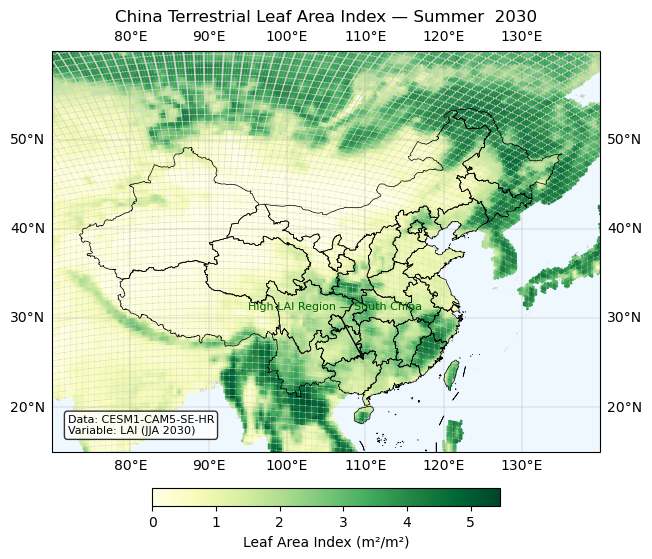

In [43]:

# ========== 2.2 ==========
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import shapely.vectorized

# ========== 打开CESM LAI数据 ==========
ds = xr.open_dataset("lai_Lmon_CESM1-CAM5-SE-HR_highres-future_r1i1p1f1_gn_201501-205012.nc")

lai_2030_summer = ds["lai"].sel(time=slice("2030-06","2030-08")).mean(dim="time")
lat = ds["lat"].values
lon = ds["lon"].values
lai_vals = lai_2030_summer.values

# ========== 构造陆地mask ==========
land_feature = cfeature.NaturalEarthFeature("physical", "land", "110m")
land_geoms = list(land_feature.geometries())

# 判断格点是否在陆地内
mask_land = np.zeros(len(lat), dtype=bool)
for geom in land_geoms:
    mask_land |= shapely.vectorized.contains(geom, lon, lat)

lai_land = np.where(mask_land, lai_vals, np.nan)

# ========== 加载中国省级边界 ==========
china_provinces_url = "https://geo.datav.aliyun.com/areas_v3/bound/100000_full.json"
provinces = gpd.read_file(china_provinces_url).to_crs(epsg=4326)

# ========== 绘图 ==========
plt.figure(figsize=(9,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([70, 140, 15, 55])

# 背景层
ax.add_feature(cfeature.LAND, facecolor="lightgray", zorder=0)
ax.add_feature(cfeature.OCEAN, facecolor="aliceblue", zorder=0)

# 边界 (features)
provinces.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.5, zorder=3)

# 仅绘制陆地点（已mask）
sc = ax.scatter(lon, lat, c=lai_land, s=1, cmap="YlGn",
                transform=ccrs.PlateCarree(), zorder=2)

# 色标
cb = plt.colorbar(sc, orientation="horizontal", pad=0.05, fraction=0.4, shrink=0.4)
cb.set_label("Leaf Area Index (m²/m²)")

# 标题与图例
plt.title("China Terrestrial Leaf Area Index — Summer  2030",
          fontsize=12)
ax.gridlines(draw_labels=True, linewidth=0.3, color="gray", alpha=0.6)

# 说明文字
ax.text(72, 17, "Data: CESM1-CAM5-SE-HR\nVariable: LAI (JJA 2030)",
        fontsize=8, transform=ccrs.PlateCarree(),
        bbox=dict(facecolor="white", alpha=0.8, boxstyle="round,pad=0.3"))

# 注释示例
ax.annotate("High LAI Region — South China",
            xy=(110, 25), xytext=(95, 31),
            arrowprops=dict(facecolor="darkgreen", arrowstyle="->"),
            fontsize=8, color="darkgreen", transform=ccrs.PlateCarree())

plt.tight_layout()
plt.show()



In [37]:
lon

array([9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
       1.34664566e+02, 1.35335434e+02, 1.35000000e+02])